# BeatSaver API usage and Data Processing notebook

This notebook is for developing code associated with downloading Beat Saber custom songs and mappings from the BeatSaver API. Goals include:

- Exploratory Data Analyses
- Systematically download songs, maps, and associated metadata
- Process data
- Save data to database

In [1]:
import numpy as np
import pandas as pd
import librosa
import json
import requests
import pickle
import matplotlib.pyplot as plt

1. Download metadata from all beatsaver records
2. Examine distribution of level difficulties and other EDA
3. Extract download link for records
4. Save links in a list for iteration

## Download metadata
This section contains functions and code to download metadata from the beatsaver.com API.

In [35]:
def api_call(page):
    """Downloads json file from beatsaver.com API at given 'page'. Only downloads if status is 200, otherwise throws
    an error. Each page in this API stores 10 records, as well as information about the page."""
    call = requests.get(f"https://beatsaver.com/api/maps/latest/{page}")
    if call.status_code == 200:
        json = call.json()
        next_page = json['nextPage']
        return json, next_page
    else:
        print(f"API call failed with error code: {call.status_code} at page: {page}")

In [115]:
def get_metadata(limit, init_page = 1):
    """Function that will iterate through all pages of beatsaver.com api to download metadata. 'limit' is the maximum
    page number to download to, 'init_page' is the first page number to start downloading from. There seems to be a 
    1000-call limit on this API."""
    page = init_page
    metadata = []
    json, next_page = api_call(page)
    for x in range(len(json['docs'])):
        metadata.append(json['docs'][x])
    while next_page < limit:
        page = next_page
        json, next_page = api_call(page)
        for x in range(len(json['docs'])):
            metadata.append(json['docs'][x])
        if next_page == 'None' or next_page == None:
            break
    return metadata    

In [110]:
#Original code to download and save metadata locally. Uncomment to run and save yourself (may need to add more lines
#of the get_metadata function).

#metadata = get_metadata_recursive(limit = 1000)
#metadata2 = get_metadata_recursive(limit = 2000, init_page = 1001)
#metadata3 = get_metadata_recursive(limit = 3000, init_page = 2001)
# metadata_total = []
# for x in list([metadata, metadata2, metadata3]):
#     for y in x:
#         metadata_total.append(y)

# with open('metadata.pkl', 'wb') as f:
#     pickle.dump(metadata_total, f)

In [2]:
with open('metadata.pkl', 'rb') as f:
    metadata_total = pickle.load(f)

## Metadata analysis
This section contains functions and code to analyze the metadata for various features, such as the distribution of difficulty levels in custom songs, descriptive statistics of the different difficulty levels, and how many songs have been released over time.

In [3]:
def difficulty_dist(metadata):
    """Counts the number of representatives for each difficulty level in the list of metadata."""
    difficulty = {'easy': 0, 'normal': 0, 'hard': 0, 'expert': 0, 'expertPlus': 0}
    for x in metadata:
        for level, value in list(x['metadata']['difficulties'].items()):
            if x['metadata']['difficulties'][level] == True:
                difficulty[f'{level}'] +=1
    return difficulty    

In [4]:
difficulty_dist(metadata_total)

{'easy': 2003,
 'normal': 2860,
 'hard': 6137,
 'expert': 11026,
 'expertPlus': 8568}

In [5]:
def get_features(metadata):
    """This function gets the duration and number of notes from each record in metadata."""
    features = []
    for x in metadata:
        if x['metadata']['characteristics'][0]['name'] == 'Standard':
            for level, value in x['metadata']['characteristics'][0]['difficulties'].items():
                if value != None:
                    features.append({'id': x['_id'],
                                     'difficulty': level, 
                                     'duration': value['duration'], 
                                     'notes': value['notes'],
                                     'bpm': x['metadata']['bpm']})
    return features

In [6]:
features = get_features(metadata_total)

In [7]:
def make_df_and_clean(features):
    """Coerces the features dictionary into a pandas DataFrame. Removes 0 values and values outside of middle 90%
    quantile of data from 'duration', 'notes', and 'bpm'. 
    """
    
    #Coerce into dataframe, drop zeros, add columns for notes per second and notes per beat
    df = pd.DataFrame(features)
    df = df[(df['duration'] != 0) & (df['notes'] != 0) & (df['bpm'] != 0)]
    df['notes_per_sec'] = df['notes']/df['duration']
    df['notes_per_beat'] = df['notes_per_sec'] * 60 * (df['bpm'])**(-1)   
    
    #Drop rows that are outside of the middle 90% quantiles - there are some really unusual custom mappings that
    #are not representative of normal play
    df = df[(df['duration'] > df['duration'].quantile(0.05)) &
       (df['duration'] < df['duration'].quantile(0.95)) &
       (df['notes'] > df['notes'].quantile(0.05)) &
       (df['notes'] < df['notes'].quantile(0.95)) &
       (df['bpm'] > df['bpm'].quantile(0.05)) &
       (df['bpm'] < df['bpm'].quantile(0.95))]
    
    return df 

In [8]:
df = make_df_and_clean(features)

In [364]:
#Show some summary statistics by difficulty level
df.groupby('difficulty').describe().T

difficulty                   easy       expert   expertPlus         hard  \
duration       count   955.000000  9316.000000  6172.000000  5053.000000   
               mean    441.957955   424.110261   444.347836   417.023538   
               std     143.059454   153.429322   163.572224   153.742383   
               min     117.500000   116.468750   116.500000   116.328003   
               25%     346.850006   312.402679   322.975014   304.413757   
               50%     433.180084   413.213837   431.210022   404.000000   
               75%     531.914612   519.000015   554.500000   510.135284   
               max     874.375000   875.000000   874.500061   875.000000   
notes          count   955.000000  9316.000000  6172.000000  5053.000000   
               mean    377.784293   712.790039   932.877835   554.501286   
               std     253.223362   277.771727   340.681354   234.363628   
               min     160.000000   168.000000   160.000000   161.000000   
               25%     231.000000   509.000000   677.000000   383.000000   
               50%     299.000000   686.000000   914.000000   522.000000   
               75%     403.500000   879.000000  1170.000000   680.000000   
               max    1748.000000  1748.000000  1754.000000  1745.000000   
bpm            count   955.000000  9316.000000  6172.000000  5053.000000   
               mean    141.390216   141.766454   154.817300   139.951114   
               std      28.615049    28.035407    29.708414    27.844467   
               min      93.000000    92.019997    93.000000    92.480003   
               25%     120.000000   120.000000   130.000000   120.000000   
               50%     136.000000   137.000000   152.209999   134.000000   
               75%     160.000000   161.000000   176.000000   160.000000   
               max     225.000000   227.000000   227.199997   227.199997   
notes_per_sec  count   955.000000  9316.000000  6172.000000  5053.000000   
               mean      0.963992     1.736985     2.193012     1.373825   
               std       0.874822     0.524938     0.697638     0.441825   
               min       0.219310     0.330237     0.303468     0.269285   
               25%       0.541193     1.396989     1.759716     1.077098   
               50%       0.687451     1.669054     2.094958     1.309297   
               75%       0.985422     1.989306     2.499050     1.591828   
               max       8.664188     8.921733    12.217392     7.103825   
notes_per_beat count   955.000000  9316.000000  6172.000000  5053.000000   
               mean      0.427928     0.779432     0.896152     0.624776   
               std       0.404165     0.330983     0.388463     0.273027   
               min       0.059812     0.145693     0.119790     0.134642   
               25%       0.221549     0.548735     0.643943     0.431021   
               50%       0.313838     0.722146     0.828482     0.577307   
               75%       0.476692     0.931031     1.044384     0.755592   
               max       4.244510     3.902945     5.224417     3.551913   

difficulty                 normal  
duration       count  2199.000000  
               mean    425.972275  
               std     146.576464  
               min     117.444443  
               25%     322.166672  
               50%     412.282196  
               75%     516.146667  
               max     875.000000  
notes          count  2199.000000  
               mean    424.926330  
               std     199.542087  
               min     160.000000  
               25%     291.000000  
               50%     382.000000  
               75%     504.500000  
               max    1727.000000  
bpm            count  2199.000000  
               mean    138.408941  
               std      28.391527  
               min      92.500000  
               25%     120.000000  
               50%     131.000000  
               75%     157.099998  
               max 

In [377]:
#Same, but only looking at mean, median, and standard deviation
df.groupby('difficulty').agg([np.median, np.mean, np.std]).T

difficulty                   easy      expert  expertPlus        hard  \
duration       median  433.180084  413.213837  431.210022  404.000000   
               mean    441.957955  424.110261  444.347836  417.023538   
               std     143.059454  153.429322  163.572224  153.742383   
notes          median  299.000000  686.000000  914.000000  522.000000   
               mean    377.784293  712.790039  932.877835  554.501286   
               std     253.223362  277.771727  340.681354  234.363628   
bpm            median  136.000000  137.000000  152.209999  134.000000   
               mean    141.390216  141.766454  154.817300  139.951114   
               std      28.615049   28.035407   29.708414   27.844467   
notes_per_sec  median    0.687451    1.669054    2.094958    1.309297   
               mean      0.963992    1.736985    2.193012    1.373825   
               std       0.874822    0.524938    0.697638    0.441825   
notes_per_beat median    0.313838    0.722146    0.828482    0.577307   
               mean      0.427928    0.779432    0.896152    0.624776   
               std       0.404165    0.330983    0.388463    0.273027   

difficulty                 normal  
duration       median  412.282196  
               mean    425.972275  
               std     146.576464  
notes          median  382.000000  
               mean    424.926330  
               std     199.542087  
bpm            median  131.000000  
               mean    138.408941  
               std      28.391527  
notes_per_sec  median    0.949789  
               mean      1.046623  
               std       0.517758  
notes_per_beat median    0.425595  
               mean      0.483418  
               std       0.282487

In order to visualize the number of official song releases vs. custom song releases, let's graph the two against each other.

Official Song Releases (as per the update release history of Beat Saver):
- May 1, 2018: 10 songs
- July 20, 2018: 1 song
- Dec 14, 2018: 1 song
- Dec 21, 2018: 1 song
- March 14, 2019: 10 songs (DLC)
- March 14, 2019: 5 songs
- April 1, 2019: 1 song
- June 10, 2019: 10 songs (DLC)
- Aug 29, 2019: 6 songs (DLC)
- October 4, 2019: 4 songs (DLC)
- November 7, 2019: 6 songs (DLC)
- December 13, 2019: 6 songs (DLC)

In [12]:
#Create columns for official song releases
official_dates = ['2018-05-01', 
                  '2018-05-01',
                  '2018-05-01',
                  '2018-05-01',
                  '2018-05-01',
                  '2018-05-01',
                  '2018-05-01',
                  '2018-05-01',
                  '2018-05-01',
                  '2018-05-01',
                  '2018-07-20', 
                  '2018-12-14', 
                  '2018-12-21', 
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-03-14',
                  '2019-04-01',
                  '2019-06-10',
                  '2019-06-10',
                  '2019-06-10',
                  '2019-06-10',
                  '2019-06-10',
                  '2019-06-10',
                  '2019-06-10',
                  '2019-06-10',
                  '2019-06-10',
                  '2019-06-10',
                  '2019-08-29',
                  '2019-08-29',
                  '2019-08-29',
                  '2019-08-29',
                  '2019-08-29',
                  '2019-08-29',
                  '2019-10-04',
                  '2019-10-04',
                  '2019-10-04',
                  '2019-10-04',
                  '2019-11-07',
                  '2019-11-07',
                  '2019-11-07',
                  '2019-11-07',
                  '2019-11-07',
                  '2019-11-07',
                  '2019-12-13',
                  '2019-12-13',
                  '2019-12-13',
                  '2019-12-13',
                  '2019-12-13',
                  '2019-12-13']
official = []
for x in range(len(official_dates)):
    official.append('official')

df_official = pd.DataFrame([np.array(official_dates), np.array(official)]).T
df_official['date'] = df_official[0]
df_official['releaser'] = df_official[1]
df_official.drop([0, 1], axis = 1, inplace = True)

In [25]:
#Create columns for custom song releases
dates = pd.DataFrame([x['uploaded'] for x in metadata_total])
dates['datetime'] = pd.to_datetime(dates[0])
dates.drop(labels = 0, axis = 1, inplace = True)
dates['date'] = dates['datetime'].dt.date
dates['releaser'] = 'custom'
dates.drop('datetime', axis = 1, inplace = True)

In [68]:
#Create DataFrame of both custom and official songs
all_dates = pd.concat([dates, df_official], axis = 0, ignore_index=True)
all_dates.index = pd.to_datetime(all_dates['date'])

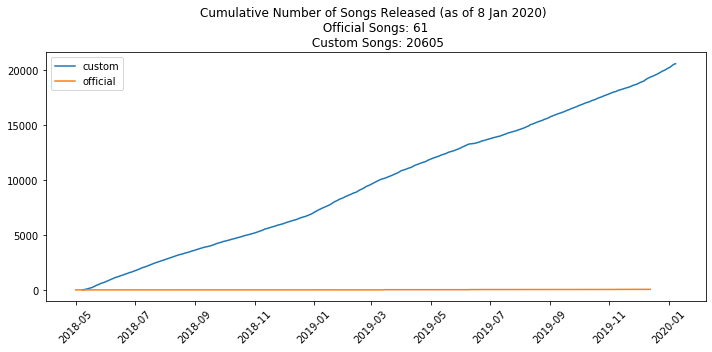

In [145]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(all_dates[all_dates['releaser'] == 'custom'].resample('d').count().cumsum()['releaser'], label = 'custom')
ax.plot(all_dates[all_dates['releaser'] == 'official'].resample('d').count().cumsum()['releaser'], label = 'official')
ax.legend()
plt.title(f"Cumulative Number of Songs Released (as of 8 Jan 2020) \n Official Songs: {all_dates[all_dates['releaser'] == 'official'].resample('d').count().cumsum()['releaser'][-1]} \n Custom Songs: {all_dates[all_dates['releaser'] == 'custom'].resample('d').count().cumsum()['releaser'][-1]}")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('Figure1_CumulativeSongsReleased.png', dpi = 200);